# Pylops - signal processing

### Author: M.Ravasi

In this notebook I will show how to use some of the linear operators for signal processing in *Pylops*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.signal import fftconvolve
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

# just for comparison
from Convolve1D_old import Convolve1D as Convolve1D_old
from Convolve2D_old import Convolve2D as Convolve2D_old

## FFT

We are now interested to apply the forward Fourier transform to a signal $d(t)$:

$$D(f) = \int d(t) e^{-j2\pi ft} dt = \mathscr{F} (d)$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F} \mathbf{d}$$

Similarly we would like to apply the inverse Fourier transform (that in this special case is equivalent to the adjoint of operator $\mathbf{F}$):

$$d(t) = \int D(f) e^{j2\pi ft} df = \mathscr{F}^{-1} (d) $$

which is 

$$\mathbf{d}= \mathbf{F}^H \mathbf{D}$$

Let's start by applying this operator to a 1d signal

Dot test passed, v^H(Opu)=(-26.448961420713026+22.93195632156735j) - u^H(Op^Hv)=(-26.44896142071306+22.931956321567355j)


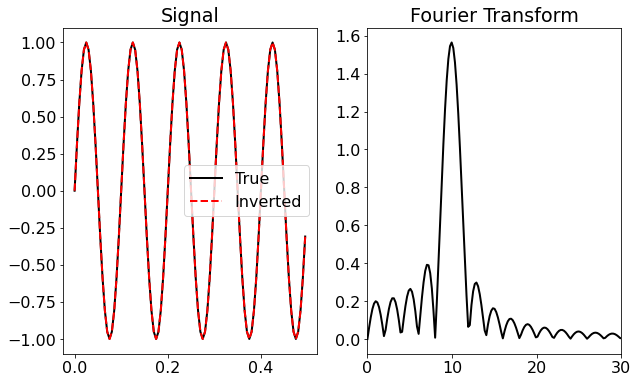

In [2]:
dt   = 0.005
nt   = 100
t    = np.arange(nt)*dt
f0   = 10
nfft = 2**10
d  = np.sin(2*np.pi*f0*t)

FFTop = FFT(dims=[nt], nfft=nfft, sampling=dt)
dottest(FFTop, nfft, nt, complexflag=3, verb=True)

D    = FFTop*d
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = FFTop / D

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].plot(t,d,    'k',  lw=2, label='True')
axs[0].plot(t,dinv,'--r',lw=2, label='Inverted')
axs[0].legend()
axs[0].set_title('Signal')
axs[1].plot(FFTop.f[:int(FFTop.nfft/2)], np.abs(D[:int(FFTop.nfft/2)]),'k',lw=2)
axs[1].set_title('Fourier Transform')
axs[1].set_xlim([0,3*f0]);

Let's look into the dot test, it works for real=False

In [3]:
nt=100
nfft=2**11
u=np.random.normal(0,1,nt)
v=np.random.normal(0,1,nfft)+1j*np.random.normal(0,1,nfft)
#v = np.sqrt(1. / nfft)*np.fft.fft(u, n=nfft)

y = np.sqrt(1. / nfft)*np.fft.fft(u, n=nfft)
x = np.sqrt(nfft)*np.fft.ifft(v)
x=x[:nt]

yy = np.vdot(y, v) # (Op  * u)' * v
xx = np.vdot(u, x) # u' * (Op' * v)

print(yy)
print(xx)
print(np.abs((yy-xx)/((yy+xx+1e-15)/2)))

(4.472281271704081-1.7868875914262272j)
(4.472281271704075-1.7868875914262135j)
3.136509260691331e-15


and for real=True if we correctly scale all elements apart from the first and the last

In [4]:
FFTop = FFT(dims=[nt], nfft=nfft, sampling=dt, real=True)
dottest(FFTop, nfft//2+1, nt, complexflag=2, verb=True)

Dot test passed, v^H(Opu)=-5.167907257702302 - u^H(Op^Hv)=-5.167907257702296


True

We now apply a fast Fourier transform to a 2d signal (along one of the axis)

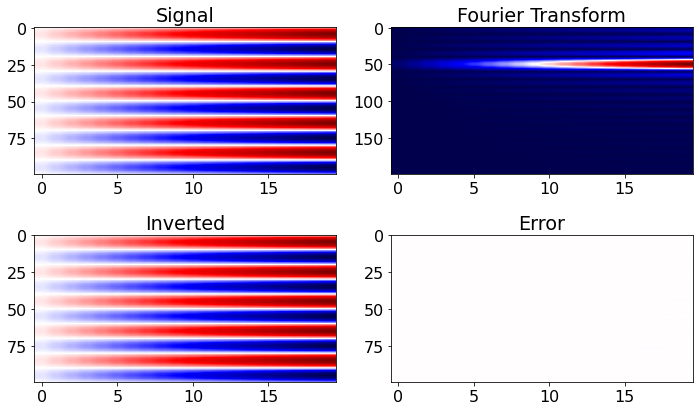

In [5]:
dt     = 0.005
nt,nx  = 100, 20
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)

FFTop = FFT(dims=[nt,nx], axis=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv = np.real(FFTop / D).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-20, vmax=20, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nfft,nx)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-20, vmax=20, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-20, vmax=20, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout();

In [6]:
FFTop = FFT(dims=[nt,nx], axis=0, nfft=nfft, sampling=dt, real=True)
dottest(FFTop, (nfft//2+1)*nx, nt*nx, complexflag=2)

True

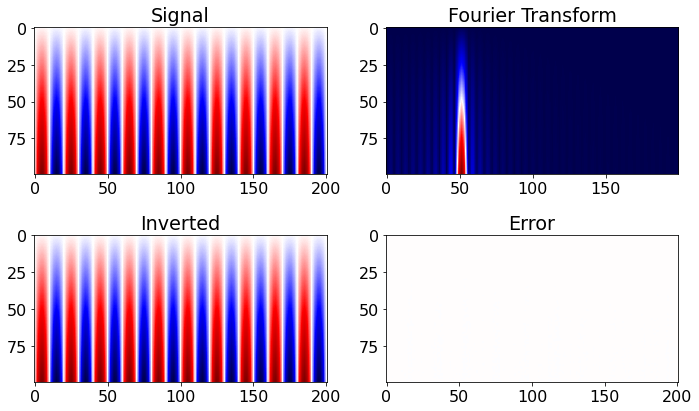

In [7]:
dx     = 0.005
nt,nx  = 100, 201
x      = np.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = np.outer(np.arange(nt)+1, np.sin(2*np.pi*f0*x))

FFTop = FFT(dims=[nt,nx], dir=1, nfft=nfft, sampling=dt)
dottest(FFTop, nt*nfft, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nt,nfft)[:,:200]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

In [8]:
FFTop = FFT(dims=[nt,nx], dir=1, nfft=nfft, sampling=dt, real=True)
dottest(FFTop, (nfft//2+1)*nt, nt*nx, complexflag=2)

True

And a 3d signal

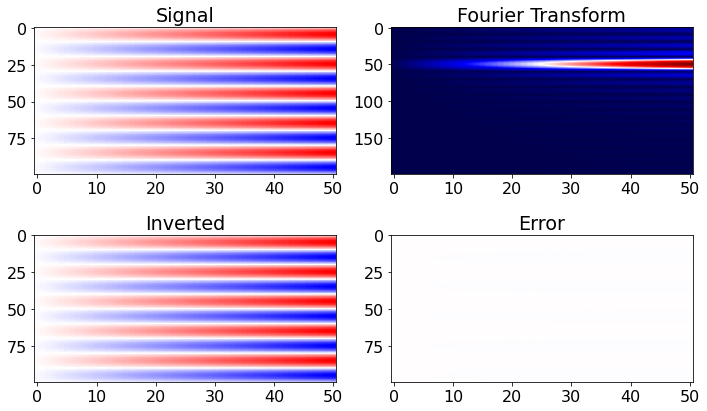

In [9]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 6
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT(dims=[nt,nx,ny], axis=0, nfft=nfft, sampling=dt)
dottest(FFTop, nfft*nx*ny, nt*nx*ny, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(D.reshape(nfft,nx,ny)[:200,:,ny//2]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d[:,:,ny//2]-dinv[:,:,ny//2], vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

In [10]:
FFTop = FFT(dims=[nt,nx,ny], axis=0, nfft=nfft, sampling=dt, real=True)
dottest(FFTop, (nfft//2+1)*nx*ny, nt*nx*ny, complexflag=2)

True

Let's try now the fftw implementation

In [11]:
dt = 0.005
nt = 100
t = np.arange(nt)*dt
f0 = 10
nfft = 2**10
d = np.sin(2*np.pi*f0*t)

FFTop = FFT(dims=nt, nfft=nfft, sampling=dt)
D = FFTop*d
dadj = FFTop.H*D

FFTop1 = FFT(dims=nt, nfft=nfft, sampling=dt, engine='fftw')
D1 = FFTop1*d
d1adj = FFTop1.H*D

print(D-D1)
print(dadj-d1adj)
dottest(FFTop, nfft, nt, complexflag=2)
dottest(FFTop1, nfft, nt, complexflag=2)

[ 0.00000000e+00+0.00000000e+00j  1.38777878e-17-6.93889390e-18j
  1.38777878e-17-1.38777878e-17j ...  2.77555756e-17-4.16333634e-17j
 -1.38777878e-17+0.00000000e+00j -4.85722573e-17-3.46944695e-17j]
[ 0.00000000e+00+0.00000000e+00j  1.11022302e-16-1.92987987e-17j
  0.00000000e+00+2.60970381e-17j  0.00000000e+00-3.90312782e-18j
  0.00000000e+00-3.03576608e-18j  0.00000000e+00+3.26599652e-17j
  0.00000000e+00-2.66713734e-17j  0.00000000e+00-4.25007252e-17j
  0.00000000e+00-1.30104261e-17j  1.11022302e-16+3.68628739e-18j
 -1.90819582e-17+4.47775497e-17j  5.55111512e-17+3.90312782e-18j
 -1.11022302e-16+2.60208521e-18j  1.11022302e-16+2.12503626e-17j
  0.00000000e+00+0.00000000e+00j  1.11022302e-16+2.59571886e-17j
  1.11022302e-16-3.11017396e-18j -2.22044605e-16-1.09100464e-17j
  1.11022302e-16-1.99376765e-17j -1.11022302e-16+1.50427810e-17j
 -4.73316284e-17-2.24105054e-17j -5.55111512e-17-4.71074833e-17j
  0.00000000e+00-6.02008497e-17j  0.00000000e+00-6.10129532e-17j
  1.11022302e-16-1.4

True

In [12]:
FFTop1 = FFT(dims=nt, nfft=nfft, sampling=dt, engine='fftw', real=True)
dottest(FFTop1, nfft//2+1, nt, complexflag=2)

True

## FFT2

Similarly to the 1d Fourier transform, we can create an operator to apply 2d FFT to a signal $d(y,x)$:

$$D(k_y, k_x) = \int \int d(y,x) e^{-j2\pi k_y y}  e^{-j2\pi k_x x} dy dx $$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{D}= \mathbf{F_2} \mathbf{d}$$

Similarly we would like to apply the inverse Fourier transform (that in this special case is equivalent to the adjoint of operator $\mathbf{F}$):

$$d(y,x) = \int \int D(k_y, k_x) e^{j2\pi k_y y}   e^{j2\pi k_xx} dk_y dk_x $$

which is 

$$\mathbf{d}= \mathbf{F_2}^H \mathbf{D}$$

Apply 2d Fourier transform to 2d data

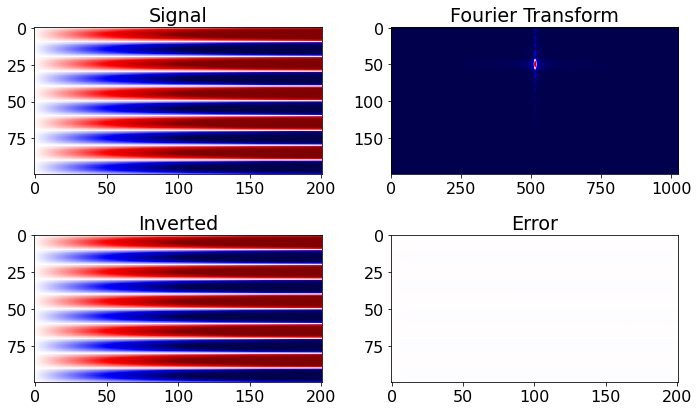

In [13]:
dt, dx = 0.005, 5
nt,nx  = 100, 201
t      = np.arange(nt)*dt
x      = np.arange(nx)*dx
f0     = 10
nfft   = 2**10
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)

FFTop = FFT2D(dims=[nt,nx], nffts=[nfft,nfft], sampling=[dt,dx])
dottest(FFTop, nfft*nfft, nt*nx, complexflag=2)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=1000 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx)

fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0][0].imshow(d, vmin=-100, vmax=100, cmap='seismic')
axs[0][0].set_title('Signal')
axs[0][0].axis('tight')
axs[0][1].imshow(np.abs(np.fft.fftshift(D.reshape(nfft,nfft),axes=1)[:200,:]), cmap='seismic')
axs[0][1].set_title('Fourier Transform')
axs[0][1].axis('tight')
axs[1][0].imshow(dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight')
axs[1][1].imshow(d-dinv, vmin=-100, vmax=100, cmap='seismic')
axs[1][1].set_title('Error')
axs[1][1].axis('tight')
fig.tight_layout()

Dot test passed, v^H(Opu)=-381.4165749947049 - u^H(Op^Hv)=-381.4165749947057


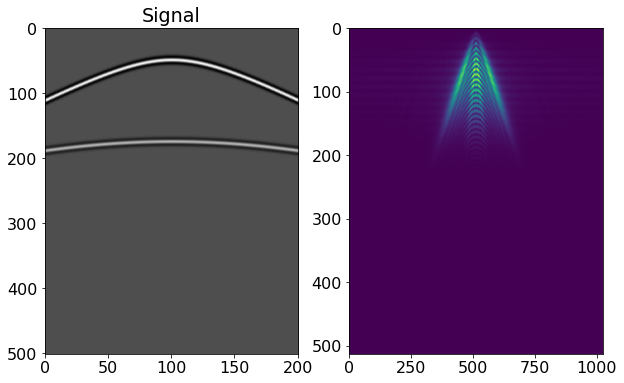

In [14]:
par = {'ox':-200, 'dx':2, 'nx':201,
       'oy':-100, 'dy':2, 'ny':101,
       'ot':0, 'dt':0.004, 'nt':501,
       'f0': 20, 'nfmax': 210}
nt, nx = par['nt'], par['nx']
nfft   = 2**10

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(np.arange(41) * par['dt'], f0=par['f0'])[0]

vrms = [500, 700]
t0 = [0.2, 0.7]
theta = [40, 0]
amp = [1., 0.6]

mhyp, mhypwav = hyperbolic2d(x, t, t0, vrms, amp, wav)

FFTop = FFT2D(dims=[nx,nt], nffts=[nfft,nfft], sampling=[dx,dt], real=True)
dottest(FFTop, nfft*(nfft//2+1), nt*nx, complexflag=2, verb=True)

Mhypwav = FFTop * mhypwav.ravel()
mhypwav = FFTop.H * Mhypwav
mhypwav = mhypwav.reshape(nx, nt)
Mhypwav = Mhypwav.reshape(nfft, nfft//2+1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(mhypwav.T, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Signal')
axs[1].imshow(np.fft.fftshift(np.abs(Mhypwav).T, axes=1))
axs[1].axis('tight');

Finally, let's apply the 2d Fourier transform to 3d data

In [15]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx], axes=(0,1))
dottest(FFTop, nfft*nfft*ny, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^H(Opu)=(-130.5012250923109-121.28512166872639j) - u^H(Op^Hv)=(-130.5012250923155-121.28512166872096j)
2.6834174408375367e-11


In [16]:
FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx], axes=(0,2))
dottest(FFTop, nfft*nx*nfft, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^H(Opu)=(43.83101068513815-343.9157007400124j) - u^H(Op^Hv)=(43.83101068514685-343.915700740009j)
1.1193749296322378e-11


In [17]:
FFTop = FFT2D(dims=[nt,nx,ny], nffts=[nfft,nfft], sampling=[dt,dx], axes=(1,2))
dottest(FFTop, nt*nfft*nfft, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
#dinv = FFTop.H*D # adjoint is inverse for fft
dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^H(Opu)=(-675.8802857185694-101.7244890786949j) - u^H(Op^Hv)=(-675.8802857185495-101.72448907869254j)
6.886619482602868e-12


## FFTN

In [18]:
dt, dx, dy = 0.005, 5, 1
nt, nx, ny  = 100, 51, 31
t      = np.arange(nt)*dt
f0     = 10
nfft   = 2**8
d      = np.outer(np.sin(2*np.pi*f0*t), np.arange(nx)+1)
d      = np.tile(d[:,:,np.newaxis], [1,1,ny])

FFTop = FFTND(dims=[nt,nx,ny], nffts=[nfft,nfft,nfft], sampling=[dt,dx,dy], axes=(0,1,2))
dottest(FFTop, nfft*nfft*nfft, nt*nx*ny, complexflag=2, verb=True)

D    = FFTop*d.flatten()
dinv = FFTop.H*D # adjoint is inverse for fft
#dinv, istop, itn, r1norm, r2norm = lsqr(FFTop, D, damp=1e-10, iter_lim=40 ,show=0)[0:5]
dinv = np.real(dinv).reshape(nt,nx,ny)

print(np.linalg.norm(d-dinv))

Dot test passed, v^H(Opu)=(-69.40087492892596-506.35267687759233j) - u^H(Op^Hv)=(-69.4008749289024-506.3526768776115j)
1.23400195266651e-12


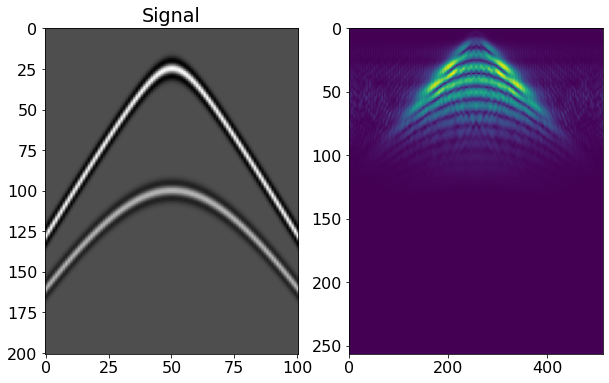

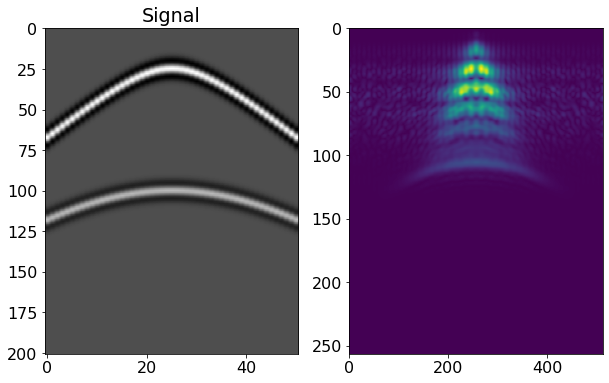

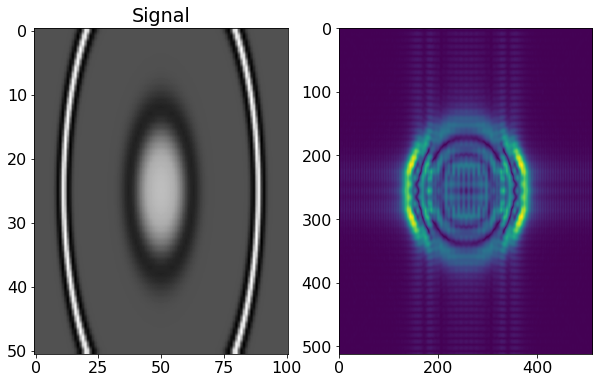

In [19]:
par = {'ox':-100, 'dx':2, 'nx':101,
       'oy':-50, 'dy':2, 'ny':51,
       'ot':0, 'dt':0.004, 'nt':201,
       'f0': 20, 'nfmax': 210}
nt, nx, ny = par['nt'], par['nx'], par['ny']
nfft   = 2**9

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(np.arange(41) * par['dt'], f0=par['f0'])[0]

vrms = [200, 200]
t0 = [0.1, 0.4]
theta = [40, 0]
amp = [1., 0.6]

mhyp, mhypwav = hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)

FFTop = FFTND(dims=[ny,nx,nt], nffts=[nfft,nfft,nfft], sampling=[dy,dx,dt], real=True)
#dottest(FFTop, nfft*nfft*(nfft//2+1), nt*nx*ny, complexflag=2, verb=True)

Mhypwav = FFTop * mhypwav.ravel()
mhypwav = FFTop.H * Mhypwav
mhypwav = mhypwav.reshape(ny, nx, nt)
Mhypwav = Mhypwav.reshape(nfft, nfft, nfft//2+1)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(mhypwav[par['ny']//2].T, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Signal')
axs[1].imshow(np.fft.fftshift(np.abs(Mhypwav[nfft//2]).T, axes=1))
axs[1].axis('tight')

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(mhypwav[:, par['nx']//2].T, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Signal')
axs[1].imshow(np.fft.fftshift(np.abs(Mhypwav[:, nfft//2]).T, axes=1))
axs[1].axis('tight')

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(mhypwav[..., nt//2], cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Signal')
axs[1].imshow(np.fft.fftshift(np.abs(Mhypwav[..., 50])))
axs[1].axis('tight');

## 1d Convolution

We create an operator that applies convolution with a kernel $k(t)$ to the input signal $x(t)$:

$$y(t) = \int_{-\inf}^{\inf} h(t-\tau) x(\tau) d\tau $$

This operation can be discretized as follows

$$y[n] = \sum_{m=-\inf}^{\inf} h[n-m] x[m] $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C} \mathbf{x}$$

As convolution can be also performed in the frequency domain

$$Y(f) = {F}(h(t)) * {F} (x(t))  $$

the adjoint operation is equivalent to correlation:

$$y(t) = {F}^{-1} ({F}(h(f))^* * (X(f)) $$

which in time domain can be written as 

$$x(t) = \int_{-\inf}^{\inf} h(t+\tau) x(\tau) d\tau $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C}^H \mathbf{x}$$

In [20]:
nx = 10
x  = np.zeros(nx)
x[3]=1
offset=4
h = np.arange(-3, 3)
print(h)
Cop = Convolve1D(nx, h=h, offset=offset, 
                 dtype='float32', 
                 method='direct')
dottest(Cop, nx, nx, verb=True)

y    = Cop*x
xadj = Cop.H*x

print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

[-3 -2 -1  0  1  2]
Dot test passed, v^H(Opu)=13.144421100783175 - u^H(Op^Hv)=13.144421100783175
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [ 0.  0.  2.  1.  0. -1. -2. -3.  0.  0.]


In [21]:
Cop = Convolve1D_old(nx, h=h, offset=offset, dtype='float32')
Cop.matvec_count = Cop.rmatvec_count = 0
dottest(Cop, nx, nx, verb=True)

y    = Cop*x
xadj = Cop.H*x

print('x= ',x)
print('y= ',y)
print('xadj= ',xadj)

Dot test passed, v^H(Opu)=-3.0738406934693243 - u^H(Op^Hv)=-3.0738406934693243
x=  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
y=  [-2. -1.  0.  1.  2.  0.  0.  0.  0.  0.]
xadj=  [[ 0.]
 [ 0.]
 [ 2.]
 [ 1.]
 [ 0.]
 [-1.]
 [-2.]
 [-3.]
 [ 0.]
 [ 0.]]


Compare with old version

In [22]:
Cop_old = Convolve1D_old(nx, h=h, offset=1, dtype='float32')
Cop_old.matvec_count = Cop_old.rmatvec_count = 0


%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

17.2 µs ± 1.69 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
18.9 µs ± 2.73 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
17.9 µs ± 1.73 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
16.9 µs ± 1.71 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Dot test passed, v^H(Opu)=48.77789848691073 - u^H(Op^Hv)=48.77789848691072


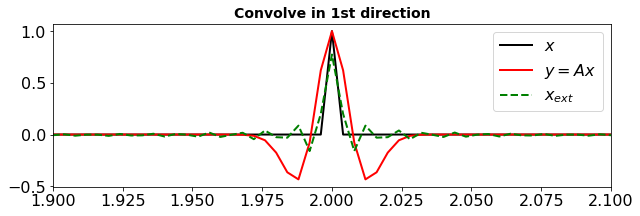

In [23]:
nt = 1001
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)
    
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x,'k'      ,lw=2, label=r'$x$')
ax.plot(t, y,'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, xlsqr,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(1.9,2.1);

We take now a non-zero wavelet (not centered at its peak)

Dot test passed, v^H(Opu)=-89.98939655676311 - u^H(Op^Hv)=-89.98939655676314


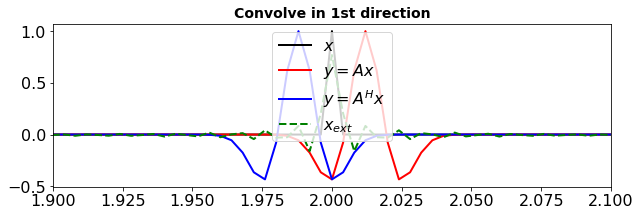

In [24]:
nt = 1001
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[int(nt/2)] = 1

h, th, hcenter = ricker(t[:101], f0=30)

Cop = Convolve1D(nt, h=h, offset=hcenter-3, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x
y1   = Cop.H*x


xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x, 'k'      ,lw=2, label=r'$x$')
ax.plot(t, y, 'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, y1,'b'      ,lw=2, label=r'$y=A^Hx$')
ax.plot(t, xlsqr,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(1.9,2.1);

We use a sparse solver to see if we can remove the side lobes

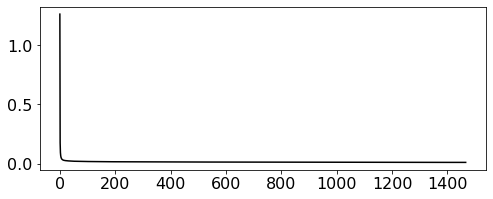

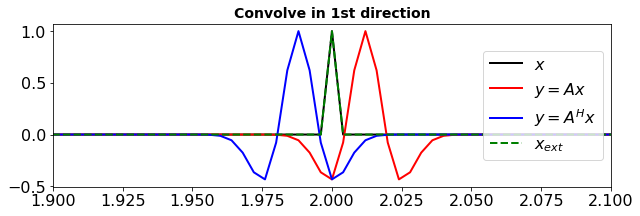

In [25]:
xista, niter, cost = ista(Cop, y, niter=10000, eps=0.01, alpha=0.1)

plt.figure(figsize=(8, 3))
plt.plot(cost, 'k')

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t, x, 'k'      ,lw=2, label=r'$x$')
ax.plot(t, y, 'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, y1,'b'      ,lw=2, label=r'$y=A^Hx$')
ax.plot(t, xista,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend(loc='right');
ax.set_xlim(1.9,2.1);

Let's now have multiple events and compare LS and sparse solver

Dot test passed, v^H(Opu)=3.7888805114165733 - u^H(Op^Hv)=3.7888820098906604
iters: 300


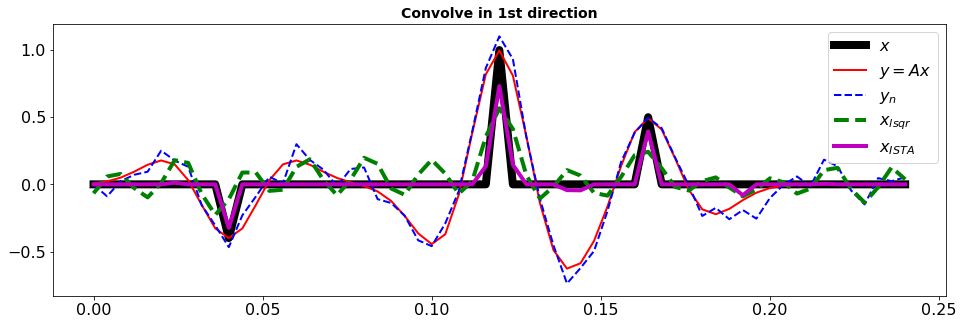

In [26]:
nt = 61
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros(nt)
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5

h, th, hcenter = ricker(t[:101], f0=20)
    
Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
dottest(Cop, nt, nt, verb=True)

y    = Cop*x
yn = y + np.random.normal(0, 0.08, y.shape)

#xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, yn, damp=1e-1, atol=1e-3, iter_lim=100, show=0)[0:5]
xlsqr, istop, itn, r1norm, r2norm = regularized_inversion(Cop, yn, None,
                                                          **dict(damp=1e-1, atol=1e-3, 
                                                                 iter_lim=100, show=0))

xista, niter, cost = ista(Cop, yn, niter=300, eps=5e-1, tol=1e-8)
print('iters:', niter)

fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(t, x,'k'      ,lw=8, label=r'$x$')
ax.plot(t, y,'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(t, yn,'--b'      ,lw=2, label=r'$y_n$')
ax.plot(t, xlsqr,'--g',lw=4, label=r'$x_{lsqr}$')
ax.plot(t, xista,'m',lw=4, label=r'$x_{ISTA}$')

ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();

Let's now consider a 2d signal

Dot test passed, v^H(Opu)=-273.1904057284736 - u^H(Op^Hv)=-273.19041071117675


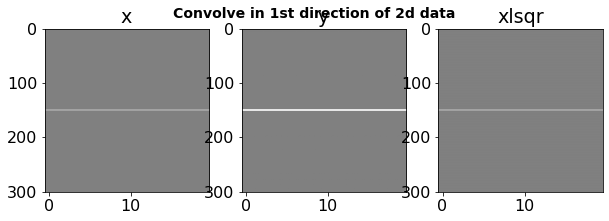

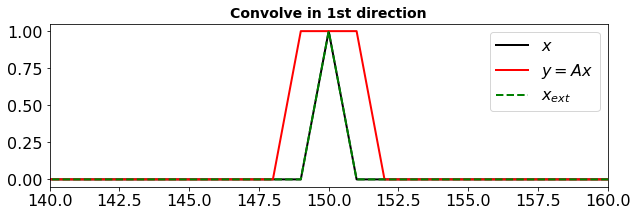

In [27]:
nt = 301
nx = 20
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx))
x[int(nt/2),:] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(dims=[nt,nx], h=h, offset=hcenter, axis=0, dtype='float32')
dottest(Cop, nt*nx, nt*nx, atol=1e-3, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 1st direction',fontsize=14, fontweight='bold')
ax.legend();
ax.set_xlim(140,160);

In [28]:
Cop_old = Convolve1D_old(nt*nx, h=h, offset=hcenter, dims=[nt,nx], dir=0, dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

94.3 µs ± 4.88 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
247 µs ± 3.93 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
89.5 µs ± 1.35 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
254 µs ± 6.83 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


And with convolution over second axis

Dot test passed, v^H(Opu)=145.61964238431239 - u^H(Op^Hv)=145.61968535894857


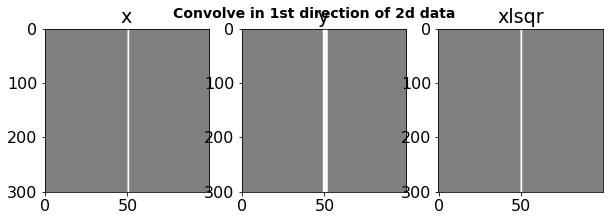

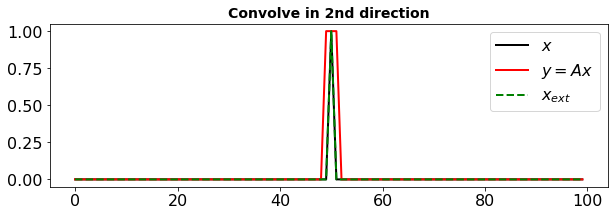

In [29]:
nt = 301
nx = 100
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx))
x[:, int(nx/2)] = 1

h = np.ones(3)
hcenter=1

Cop = Convolve1D(dims=[nt,nx], h=h, offset=hcenter, axis=-1, dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=1000, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x[int(nt/2)],'k'      ,lw=2, label=r'$x$')
ax.plot(y[int(nt/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr[int(nt/2)],'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Convolve in 2nd direction',fontsize=14, fontweight='bold')
ax.legend();

In [30]:
Cop_old = Convolve1D_old(nt*nx, h=h, offset=hcenter, dims=[nt, nx], dir=-1, dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

238 µs ± 4.03 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.06 ms ± 3.24 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
237 µs ± 2.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
1.11 ms ± 7.58 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## 2d Convolution

We want now to create an operator that applies convolution with a kernel $k(t)$ to the input signal $x(t)$:

$$y(t,x) = \int_{-\inf}^{\inf}\int_{-\inf}^{\inf} h(t-\tau,x-\chi) x(\tau,\chi) d\tau d\chi $$

This operation can be discretized as follows

$$y[i,n] = \sum_{j=-\inf}^{\inf} \sum_{m=-\inf}^{\inf} h[i-j,n-m] x[j,m] $$

and performed by means of a linear operator

$$\mathbf{y}= \mathbf{C}_2 \mathbf{x}$$

Let's apply 2d convolution on 2d signal

Dot test passed, v^H(Opu)=-875.2630326423484 - u^H(Op^Hv)=-875.2630039511139


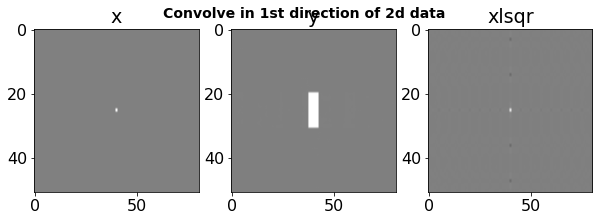

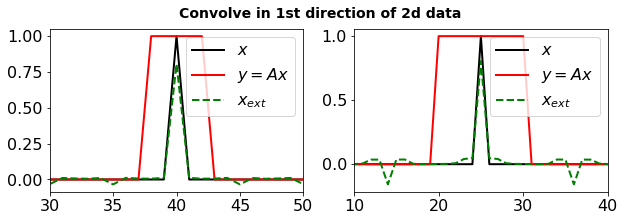

In [31]:
nt = 51
nx = 81
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = np.ones((nh[0], nh[1]))

Cop = Convolve2D(dims=[nt,nx], h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 dtype='float32')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

Same but with non-zero phase signal

Dot test passed, v^H(Opu)=117.34826071410191 - u^H(Op^Hv)=117.34834413171143


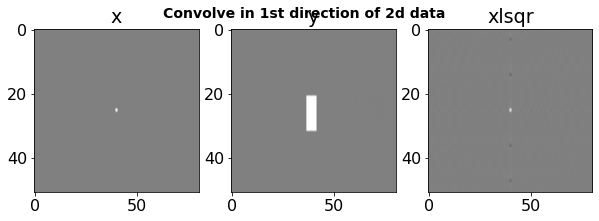

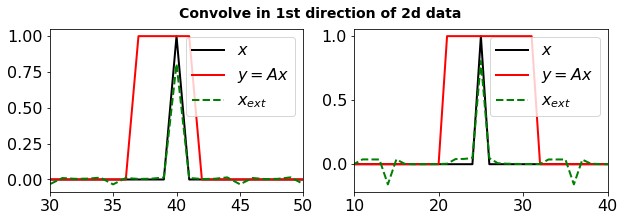

In [32]:
nt = 51
nx = 81
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt,nx))
x[int(nt/2),int(nx/2)] = 1

nh = [11,5]
h  = np.ones((nh[0],nh[1]))

Cop = Convolve2D(dims=[nt,nx], h=h, offset=[int(nh[0])/2-1,int(nh[1])/2+1], 
                 dtype='float32', method='fft')
dottest(Cop, nt*nx, nt*nx, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('xlsqr'),axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

In [33]:
Cop_old = Convolve2D_old(nt*nx, h=h, offset=[int(nh[0])/2-1,int(nh[1])/2+1], 
                         dims=[nt,nx], dtype='float32')

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())

122 µs ± 2.53 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
615 µs ± 3.85 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
124 µs ± 2.1 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
547 µs ± 2.58 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


We do the same with a oscillating filter

Dot test passed, v^H(Opu)=4.3800101529865 - u^H(Op^Hv)=4.380008610114146


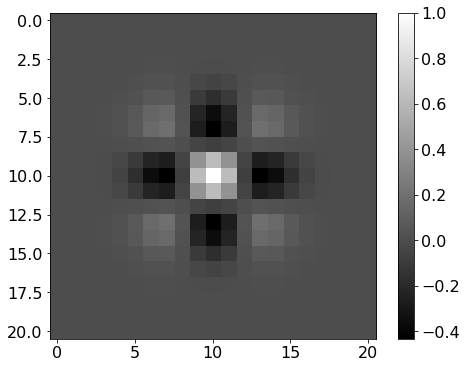

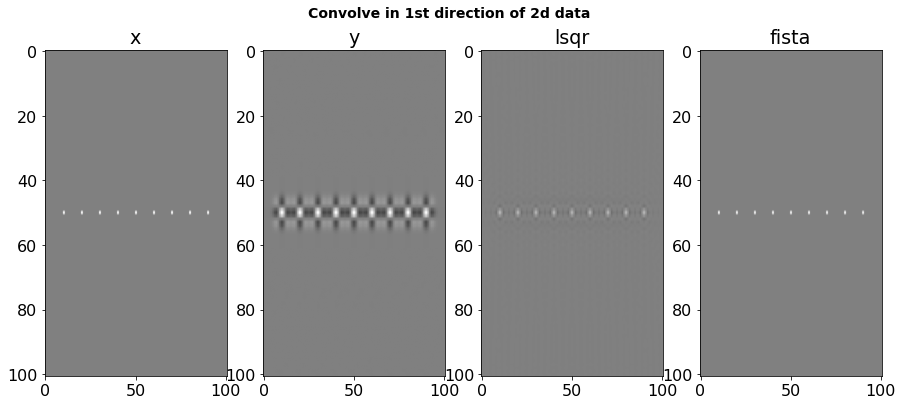

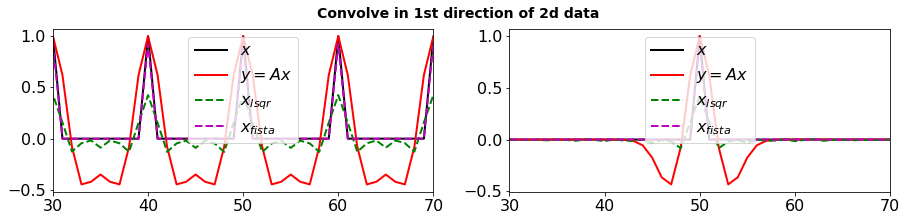

In [34]:
# create 2d wavelet
nt = 31
dt = 0.004
t  = np.arange(nt)*dt
h, th, hcenter = ricker(t, f0=30)

imp = np.zeros((21, 21))
imp[10, 10] = 1
imp = fftconvolve(imp, h[:, np.newaxis], mode='same', axes=0)
imp = fftconvolve(imp, h[np.newaxis, :], mode='same', axes=1)

plt.figure()
plt.imshow(imp, cmap='gray')
plt.colorbar()

nt = 101
nx = 101
x = np.zeros((nt,nx))
x[int(nt/2), 10:-10:10] = 1

Cop = Convolve2D(dims=[nt,nx], h=imp, offset=[imp.shape[0]//2, imp.shape[1]//2], 
                 dtype='float32')
dottest(Cop, nt*nx, nt*nx, atol=1e-3, verb=True)
y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]
xfista = fista(Cop, y, eps=1e0, niter=200, show=0)[0]

y = y.reshape(nt,nx)
xlsqr = xlsqr.reshape(nt,nx)
xfista = xfista.reshape(nt,nx)

fig, axs = plt.subplots(1,4,figsize=(15,6))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x, cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr, cmap='gray', vmin=-1, vmax=1)
axs[3].imshow(xfista, cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'),axs[0].axis('tight')
axs[1].set_title('y'),axs[1].axis('tight')
axs[2].set_title('lsqr'),axs[2].axis('tight');
axs[3].set_title('fista'),axs[3].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(15,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :],'--g',lw=2, label=r'$x_{lsqr}$')
ax[0].plot(xfista[int(nt/2), :],'--m',lw=2, label=r'$x_{fista}$')
ax[1].plot(x[:, int(nx/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2)],'--g',lw=2, label=r'$x_{lsqr}$')
ax[1].plot(xfista[:, int(nx/2)],'--m',lw=2, label=r'$x_{fista}$')
ax[0].legend();
ax[0].set_xlim(30,70);
ax[1].legend();
ax[1].set_xlim(30,70);

Let's finally apply 2d convolution on 3d signal (convolution is applied to 1st and 2nd directions)

Dot test passed, v^H(Opu)=2763.642122438916 - u^H(Op^Hv)=2763.6422529687406


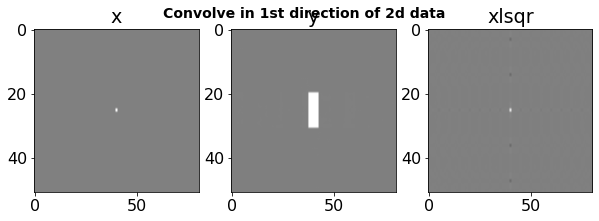

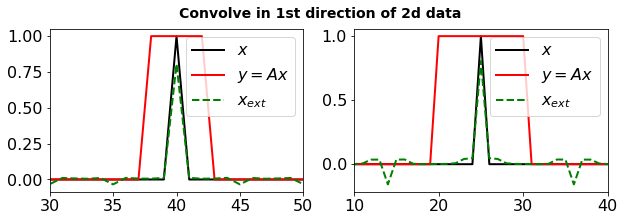

In [35]:
nt = 51
nx = 81
ny = 11
dt = 0.004
t  = np.arange(nt)*dt
x  = np.zeros((nt, nx, ny))
x[int(nt/2), int(nx/2), int(ny/2)] = 1

nh = [11,5]
h  = np.ones((nh[0], nh[1]))

Cop = Convolve2D(dims=[nt,nx,ny], h=h, offset=[int(nh[0])/2,int(nh[1])/2], 
                 axes=(0,1), dtype='float32')
dottest(Cop, nt*nx*ny, nt*nx*ny, verb=True)

y    = Cop*x.flatten()

xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(nt,nx,ny)
xlsqr = xlsqr.reshape(nt,nx,ny)

fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0].imshow(x[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[1].imshow(y[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[2].imshow(xlsqr[:, :, int(ny/2)], cmap='gray', vmin=-1, vmax=1)
axs[0].set_title('x'), axs[0].axis('tight')
axs[1].set_title('y'), axs[1].axis('tight')
axs[2].set_title('xlsqr'), axs[2].axis('tight');

fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
ax[0].plot(x[int(nt/2), :, int(ny/2)],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[int(nt/2), :, int(ny/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[int(nt/2), :, int(ny/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[:, int(nx/2), int(ny/2)],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[:, int(nx/2), int(ny/2)],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[:, int(nx/2), int(ny/2)],'--g',lw=2, label=r'$x_{ext}$')
ax[0].legend();
ax[0].set_xlim(30,50);
ax[1].legend();
ax[1].set_xlim(10,40);

In [36]:
Cop_old = Convolve2D_old(nt*nx*ny, h=h, 
                         offset=[int(nh[0])/2, int(nh[1])/2], 
                         dims=[nt,nx,ny], nodir=2, dtype='float32')
Cop_nd = ConvolveND(dims=[nt,nx,ny], h=h, 
                    offset=[int(nh[0])/2, int(nh[1])/2], 
                    axes=[0,1], 
                    dtype='float32')

y = Cop._matvec(x.flatten())
yold = Cop_old._matvec(x.flatten())
ynd = Cop_nd._matvec(x.flatten())

xadj = Cop._matvec(x.flatten())
xadjold = Cop_old._matvec(x.flatten())
xadjnd = Cop_nd._matvec(x.flatten())

print(np.allclose(y, ynd))
print(np.allclose(xadj, xadjnd))
print(np.allclose(y, yold))
print(np.allclose(xadj, xadjold))

%timeit -n 100 -r 3 Cop._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._matvec(x.flatten())
%timeit -n 100 -r 3 Cop_nd._matvec(x.flatten())

%timeit -n 100 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_old._rmatvec(x.flatten())
%timeit -n 100 -r 3 Cop_nd._rmatvec(x.flatten())

True
True
True
True
597 µs ± 6.33 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
6.74 ms ± 25.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
592 µs ± 3.16 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
599 µs ± 6.74 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
5.95 ms ± 21.5 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
593 µs ± 3.19 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


## Nd Convolution

Extension of two previous operators to N>2 dimensions

Dot test passed, v^H(Opu)=-1071.853285351869 - u^H(Op^Hv)=-1071.8533119955807


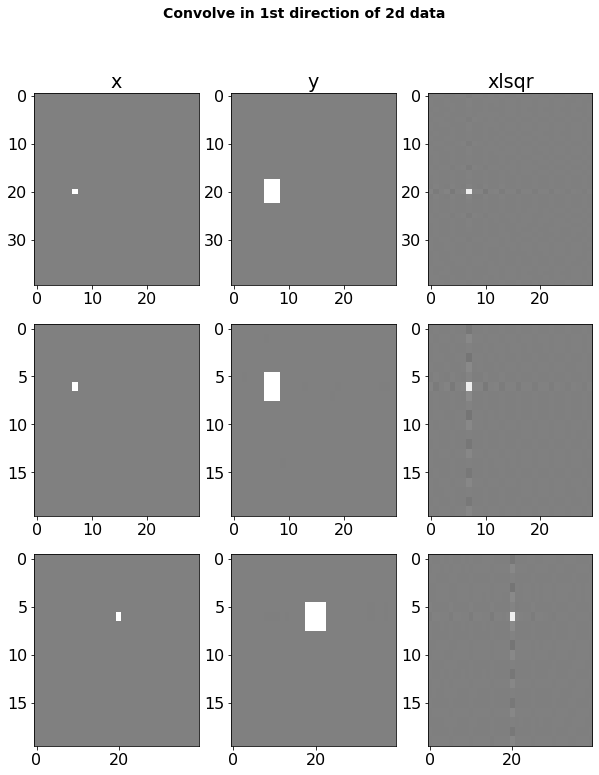

In [37]:
ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((3, 5, 3))
offset = [1, 2, 1]

Cop = ConvolveND(dims=[ny, nx, nz], h=h, offset=offset, 
                 axes=[0,1,2], dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, atol=1e-3, verb=True)

y    = Cop*x.flatten()
xlsqr, istop, itn, r1norm, r2norm = \
    lsqr(Cop, y, damp=0, iter_lim=500, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight');
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');

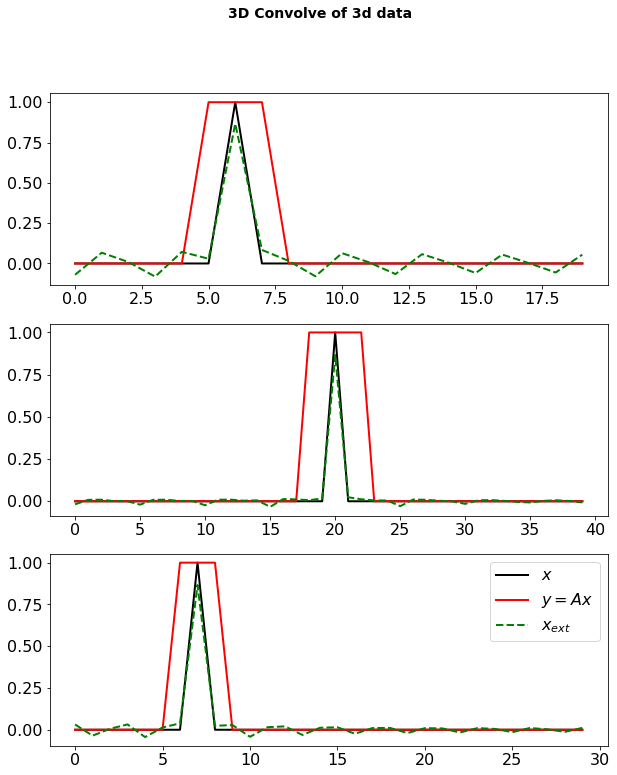

In [38]:
fig, ax = plt.subplots(3,1, figsize=(10,12))
fig.suptitle('3D Convolve of 3d data',fontsize=14, fontweight='bold')
ax[0].plot(x[:, nx//2, nz//4],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[:, nx//2, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[:, nx//2, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[ny//3, :, nz//4],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[ny//3, :, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[ny//3, :, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[2].plot(x[ny//3, nx//2], 'k', lw=2, label=r'$x$')
ax[2].plot(y[ny//3, nx//2], 'r', lw=2, label=r'$y=Ax$')
ax[2].plot(xlsqr[ny//3, nx//2],'--g',lw=2, label=r'$x_{ext}$')
ax[2].legend();

In [39]:
Cop = ConvolveND(dims=[ny, nx, nz],  h=h, offset=offset, 
                 axes=[0,1,2], dtype='float32')
Cop1 = ConvolveND(dims=[ny, nx, nz], h=h, offset=offset, 
                  axes=[0,1,2], 
                  method='fft', dtype='float32')

%timeit -n 10 -r 3 Cop._matvec(x.flatten())
%timeit -n 10 -r 3 Cop1._matvec(x.flatten())

%timeit -n 10 -r 3 Cop._rmatvec(x.flatten())
%timeit -n 10 -r 3 Cop1._rmatvec(x.flatten())

947 µs ± 37.6 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
920 µs ± 6.04 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
896 µs ± 20.5 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
919 µs ± 11.7 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


And with non-zero phase filter

Dot test passed, v^H(Opu)=-825.7359338617788 - u^H(Op^Hv)=-825.7355140201406


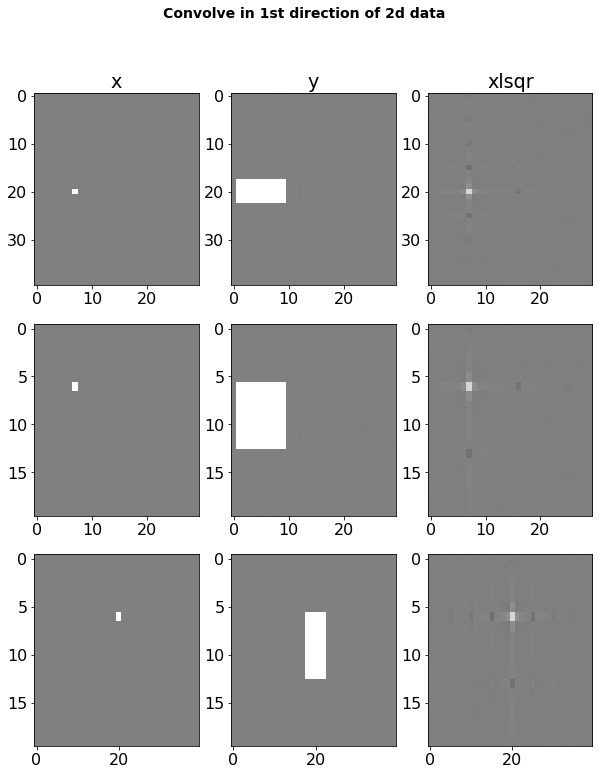

In [40]:
ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((7, 5, 9))
offset = [0, 2, 6]

Cop = ConvolveND(dims=[ny, nx, nz],  h=h, offset=offset, 
                 dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True, atol=1e-3)

y = Cop*x.flatten()
xlsqr, istop, itn, r1norm, r2norm = \
    lsqr(Cop, y, damp=0, iter_lim=300, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight');
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');

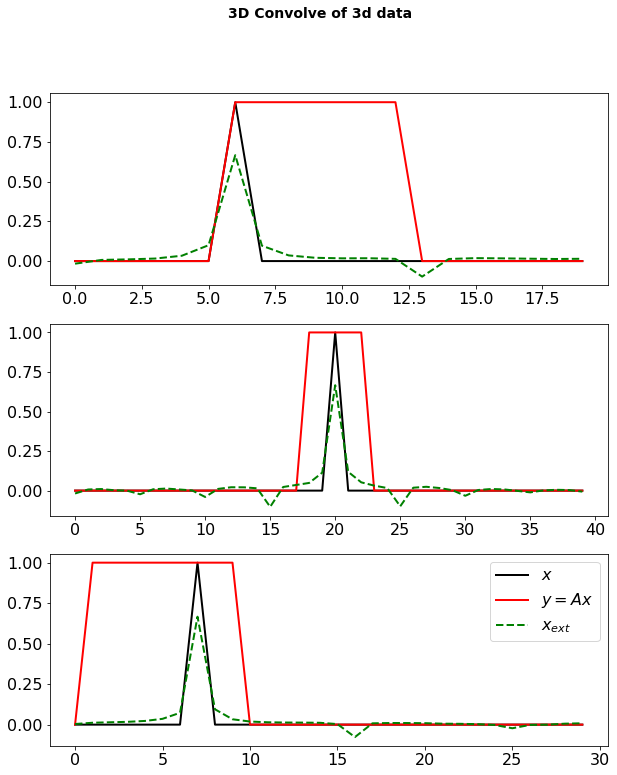

In [41]:
fig, ax = plt.subplots(3,1, figsize=(10,12))
fig.suptitle('3D Convolve of 3d data',fontsize=14, fontweight='bold')
ax[0].plot(x[:, nx//2, nz//4],'k'      ,lw=2, label=r'$x$')
ax[0].plot(y[:, nx//2, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[0].plot(xlsqr[:, nx//2, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[1].plot(x[ny//3, :, nz//4],'k'      ,lw=2, label=r'$x$')
ax[1].plot(y[ny//3, :, nz//4],'r'      ,lw=2, label=r'$y=Ax$')
ax[1].plot(xlsqr[ny//3, :, nz//4],'--g',lw=2, label=r'$x_{ext}$')
ax[2].plot(x[ny//3, nx//2], 'k', lw=2, label=r'$x$')
ax[2].plot(y[ny//3, nx//2], 'r', lw=2, label=r'$y=Ax$')
ax[2].plot(xlsqr[ny//3, nx//2],'--g',lw=2, label=r'$x_{ext}$')
ax[2].legend();

Finally we do the same with oscillating filter

Dot test passed, v^H(Opu)=71.99057896447525 - u^H(Op^Hv)=71.99054210359854


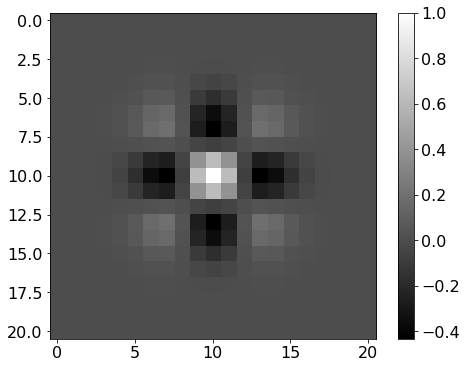

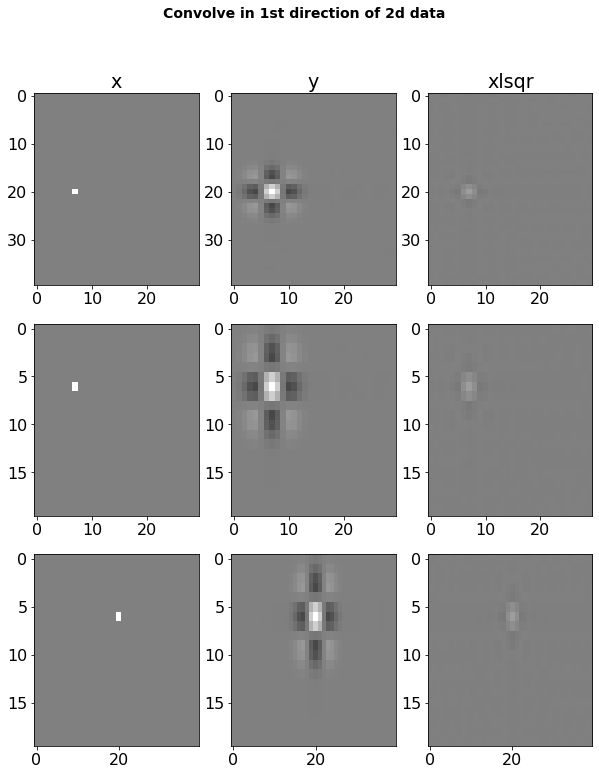

In [42]:
# create 2d wavelet
nt = 31
dt = 0.004
t  = np.arange(nt)*dt
h, th, hcenter = ricker(t, f0=30)

imp = np.zeros((21, 21, 21))
imp[10, 10, 10] = 1

imp = fftconvolve(imp, h[:, np.newaxis, np.newaxis], mode='same', axes=0)
imp = fftconvolve(imp, h[np.newaxis, :, np.newaxis], mode='same', axes=1)
imp = fftconvolve(imp, h[np.newaxis, np.newaxis, :], mode='same', axes=2)

plt.figure()
plt.imshow(imp[imp.shape[0]//2], cmap='gray')
plt.colorbar()

ny, nx, nz = 20, 40, 30
x = np.zeros((ny, nx, nz))
x[ny//3, nx//2, nz//4] = 1
h = np.ones((7, 5, 9))
offset = [10, 10, 10]

Cop = ConvolveND(dims=[ny, nx, nz], h=imp, offset=[imp.shape[0]//2, imp.shape[1]//2, imp.shape[2]//2], 
                 dtype='float32')
dottest(Cop, ny*nx*nz, ny*nx*nz, verb=True, atol=1e-4)

y = Cop * x.flatten()
xlsqr, istop, itn, r1norm, r2norm = lsqr(Cop, y, damp=0, iter_lim=300, show=0)[0:5]

y = y.reshape(ny, nx, nz)
xlsqr = xlsqr.reshape(ny, nx, nz)

fig, axs = plt.subplots(3,3,figsize=(10, 12))
fig.suptitle('Convolve in 1st direction of 2d data',fontsize=14, fontweight='bold')
axs[0][0].imshow(x[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][1].imshow(y[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][2].imshow(xlsqr[ny//3], cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('x')
axs[0][0].axis('tight')
axs[0][1].set_title('y')
axs[0][1].axis('tight')
axs[0][2].set_title('xlsqr')
axs[0][2].axis('tight')
axs[1][0].imshow(x[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][1].imshow(y[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][2].imshow(xlsqr[:, nx//2], cmap='gray', vmin=-1, vmax=1)
axs[1][0].axis('tight')
axs[1][1].axis('tight')
axs[1][2].axis('tight')
axs[2][0].imshow(x[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][1].imshow(y[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][2].imshow(xlsqr[..., nz//4], cmap='gray', vmin=-1, vmax=1)
axs[2][0].axis('tight')
axs[2][1].axis('tight')
axs[2][2].axis('tight');